# Segment Anything in Multi-Backend Keras

<a target="_blank" href="https://colab.research.google.com/github/tirthasheshpatel/segment_anything_keras/blob/main/Segment_Anything_multi_backend_Keras_Demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This demo notebook demonstrates how to use the KerasCV model API to segment images using the Segment Anything model! The demo mirrors the predictor demo on the facebookresearch/segment-anything repo.

In [1]:
# Get the dependencies
!pip install -Uq keras-cv >> /dev/null
!pip install -q git+https://github.com/tirthasheshpatel/segment_anything_keras.git >> /dev/null
!pip uninstall -y tensorflow keras keras-core >> /dev/null
!pip install -Uq keras-nightly tf-nightly tensorflow-datasets >> /dev/null
# Get the image for the demo
!curl -sSL https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg -o truck.jpg
!curl -sSL https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg -o groceries.jpg

# Imports

In [2]:
import os
os.environ['KERAS_BACKEND'] = "jax"

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import ops
from keras_cv.models import SegmentAnythingModel
from sam_keras import SAMPredictor

keras.config.disable_traceback_filtering()

In [4]:
sam = SegmentAnythingModel.from_preset("sam_huge_sa1b")

2564774344/2564774344 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step


# Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [6]:
model = SAMPredictor(sam)

In [7]:
transform  = model.transform

# Example Image

In [8]:
image = cv2.imread('truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

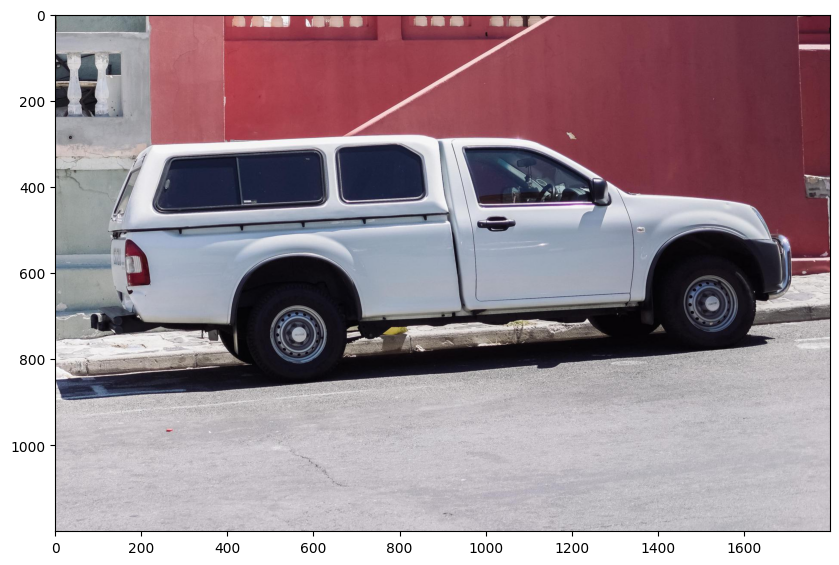

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [10]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

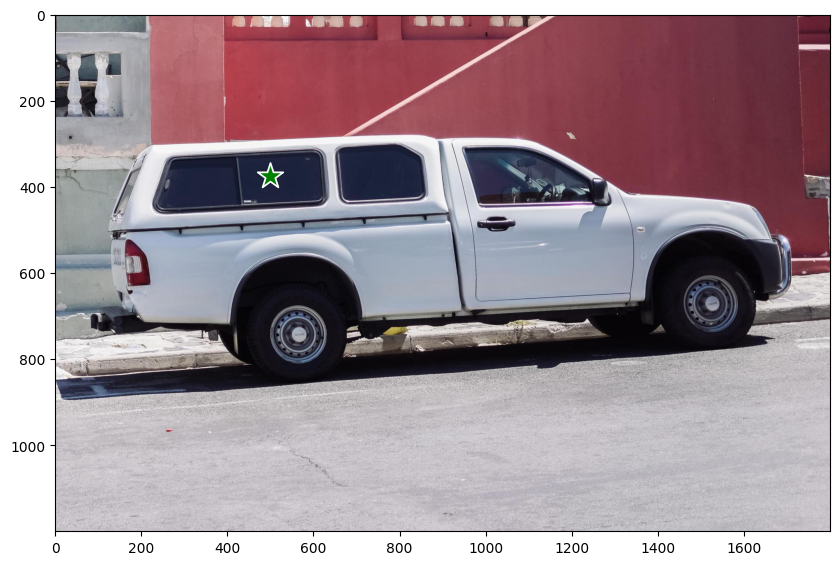

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [12]:
image_record = {}

image_record["image"] = ops.convert_to_tensor(
    transform.apply_image(image)[np.newaxis, ...],
    dtype="float32"
)

image_record["original_size"] = (image.shape[0], image.shape[1])

image_record["point_coords"] = ops.reshape(
    ops.convert_to_tensor(
        input_point, dtype="float32"
    ),
    (1, 1, 2)
)
image_record["point_coords"] = transform.apply_coords(
    image_record["point_coords"], image_record["original_size"]
)

image_record["point_labels"] = ops.convert_to_tensor(
    input_label[np.newaxis, ...],
    dtype="float32"
)

In [13]:
out = model.predict(image_record)
masks, scores, logits = out["masks"][0], out["iou_predictions"][0], out["low_res_masks"][0]
masks = ops.cast(masks > 0.0, dtype="float32")
masks, scores, logits = map(ops.convert_to_numpy, [masks, scores, logits])

1/1 ━━━━━━━━━━━━━━━━━━━━ 67s 67s/step


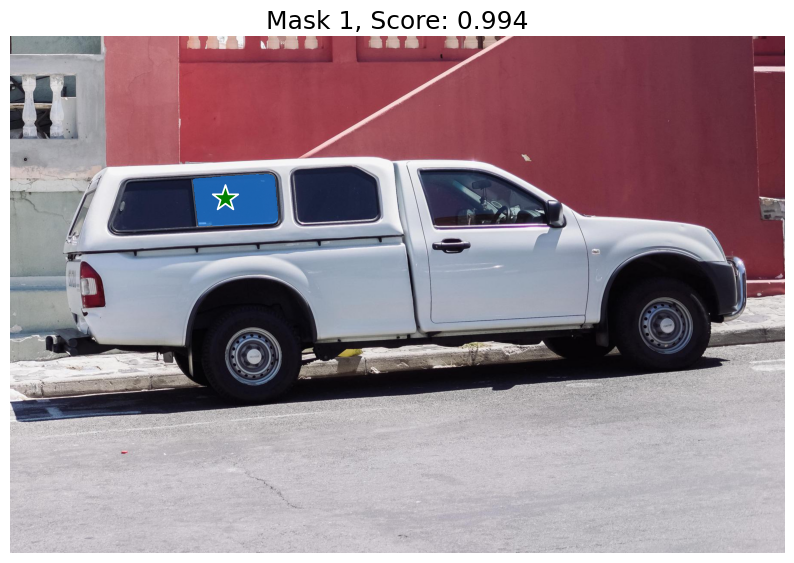

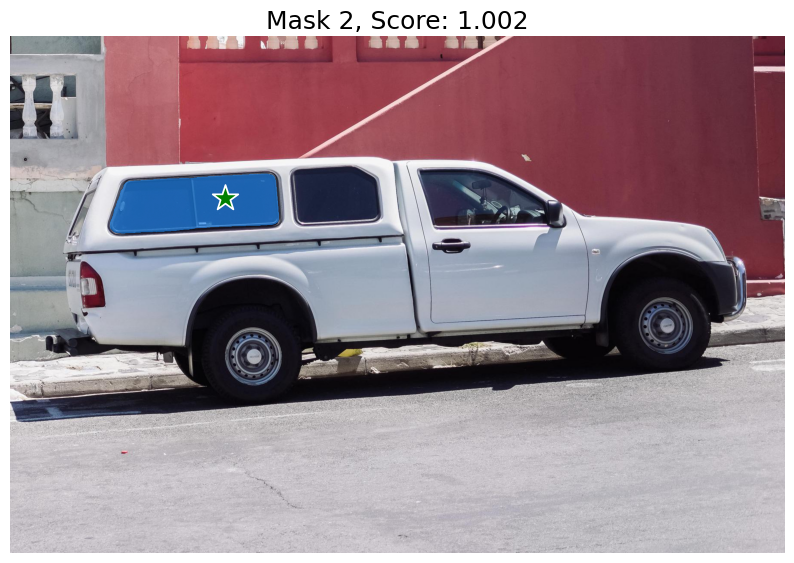

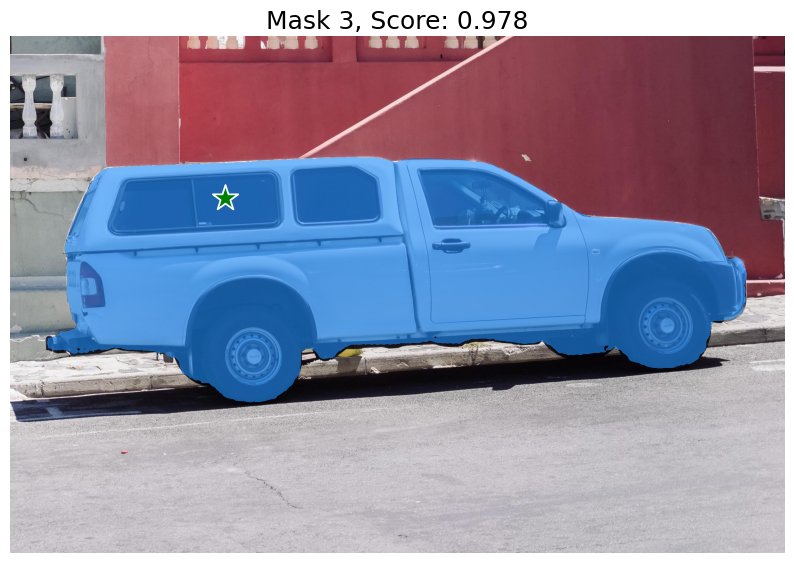

In [14]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [15]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :, np.newaxis]  # Choose the model's best mask

In [16]:
image_record["point_coords"] = ops.reshape(
    ops.convert_to_tensor(
        input_point, dtype="float32"
    ),
    (1, 2, 2)
)
image_record["point_coords"] = transform.apply_coords(
    image_record["point_coords"], image_record["original_size"]
)

image_record["point_labels"] = ops.convert_to_tensor(
    input_label[np.newaxis, ...],
    dtype="float32"
)

image_record["mask_inputs"] = ops.convert_to_tensor(mask_input[np.newaxis, np.newaxis, ...])

In [17]:
out = model.predict(image_record, multimask_output=False)
masks = out["masks"][0]
masks = ops.cast(masks > 0.0, dtype="float32")
masks = ops.convert_to_numpy(masks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


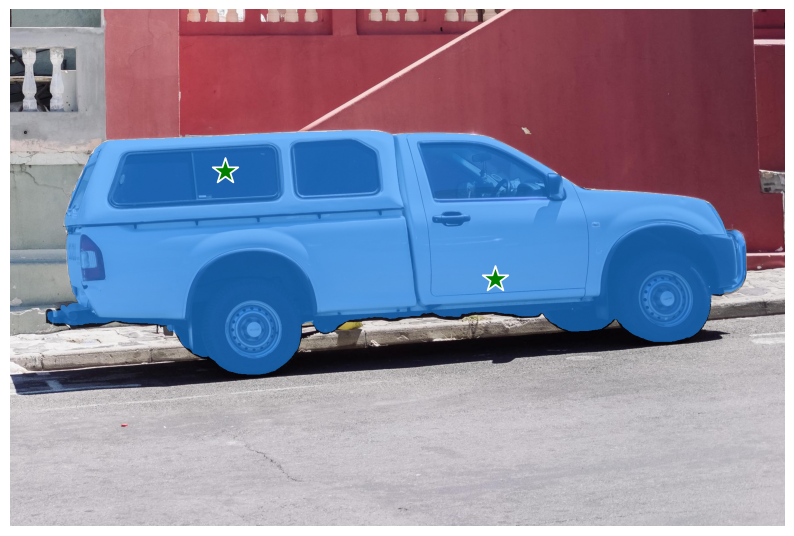

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[0, ...], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [19]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :, np.newaxis]  # Choose the model's best mask

In [20]:
image_record["point_coords"] = ops.reshape(
    ops.convert_to_tensor(
        input_point, dtype="float32"
    ),
    (1, 2, 2)
)
image_record["point_coords"] = transform.apply_coords(
    image_record["point_coords"], image_record["original_size"]
)

image_record["point_labels"] = ops.convert_to_tensor(
    input_label[np.newaxis, ...],
    dtype="float32"
)

image_record["mask_inputs"] = ops.convert_to_tensor(mask_input[np.newaxis, np.newaxis, ...])

In [21]:
out = model.predict(image_record, multimask_output=False)
masks = out["masks"][0]
masks = ops.cast(masks > 0.0, dtype="float32")
masks = ops.convert_to_numpy(masks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


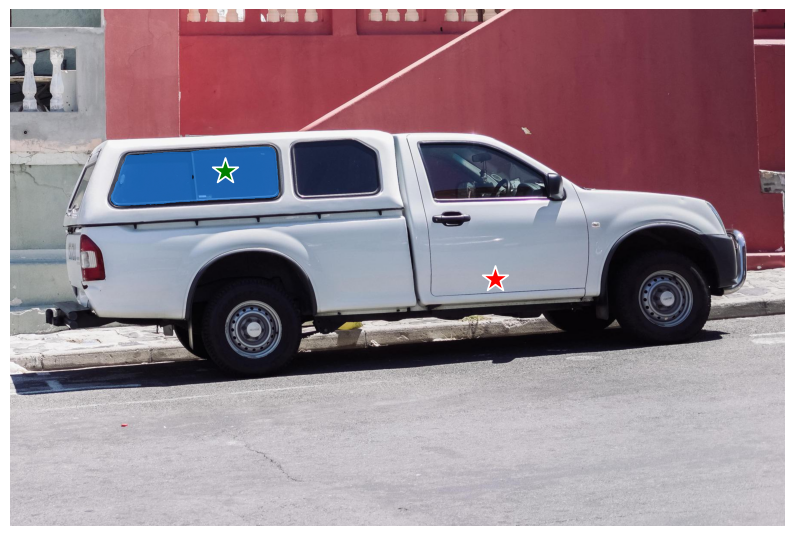

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0, ...], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

# Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [23]:
input_box = np.array([425, 600, 700, 875])

In [24]:
image_record["boxes"] = ops.reshape(
    ops.convert_to_tensor(
        input_box, dtype="float32"
    ),
    (1, 1, 4)
)
image_record["boxes"] = transform.apply_boxes(
    image_record["boxes"], image_record["original_size"]
)

In [25]:
# Remove the mask input, point_coords, and point_labels
_ = image_record.pop("mask_inputs", None)
_ = image_record.pop("point_coords", None)
_ = image_record.pop("point_labels", None)

In [26]:
out = model.predict(image_record, multimask_output=False)
masks = out["masks"][0]
masks = ops.cast(masks > 0.0, dtype="float32")
masks = ops.convert_to_numpy(masks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step


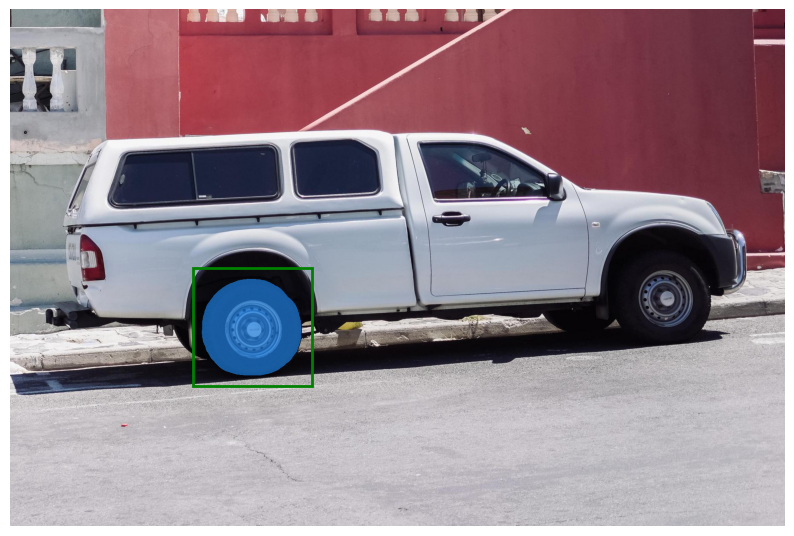

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

# Combining points and boxes

Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [28]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [29]:
image_record["point_coords"] = ops.reshape(
    ops.convert_to_tensor(
        input_point, dtype="float32"
    ),
    (1, 1, 2)
)
image_record["point_coords"] = transform.apply_coords(
    image_record["point_coords"], image_record["original_size"]
)

image_record["point_labels"] = ops.convert_to_tensor(
    input_label[np.newaxis, ...],
    dtype="float32"
)

image_record["boxes"] = ops.reshape(
    ops.convert_to_tensor(
        input_box, dtype="float32"
    ),
    (1, 1, 4)
)
image_record["boxes"] = transform.apply_boxes(
    image_record["boxes"], image_record["original_size"]
)

In [30]:
out = model.predict(image_record, multimask_output=False)
masks = out["masks"][0]
masks = ops.cast(masks > 0.0, dtype="float32")
masks = ops.convert_to_numpy(masks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


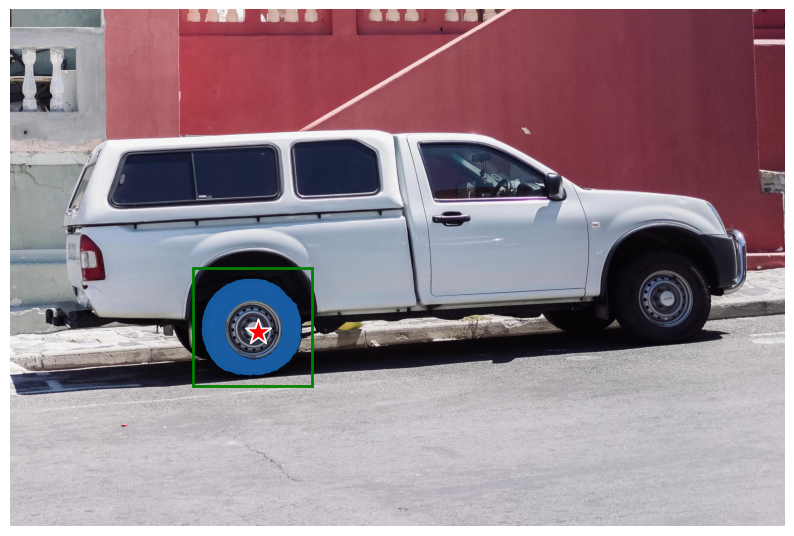

In [31]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

# Batched prompt inputs

In [32]:
input_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])

In [33]:
image_record["boxes"] = ops.reshape(
    ops.convert_to_tensor(
        input_boxes, dtype="float32"
    ),
    (4, 1, 4)
)
image_record["boxes"] = transform.apply_boxes(
    image_record["boxes"], image_record["original_size"]
)

# Remove the mask input, point_coords, and point_labels
_ = image_record.pop("mask_inputs", None)
_ = image_record.pop("point_coords", None)
_ = image_record.pop("point_labels", None)

In [34]:
out = model.predict(image_record, multimask_output=False, batch_size=1)
masks = out["masks"]
masks = ops.cast(masks > 0.0, dtype="float32")
masks = ops.convert_to_numpy(masks)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 


In [35]:
masks.shape

(4, 1, 1200, 1800)

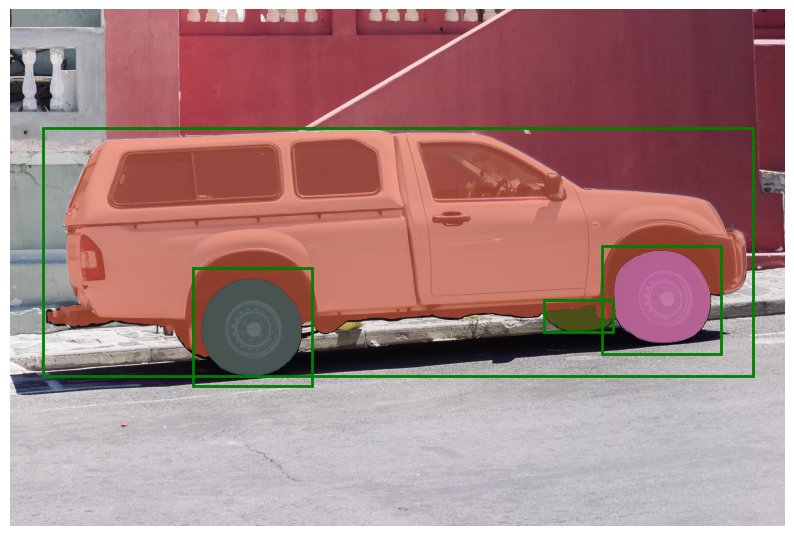

In [36]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask, plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

# End-to-end batched inference

If all prompts are available in advance, it is possible to run SAM directly in an end-to-end fashion. This also allows batching over images.

Both images and prompts are input as TensorFlow tensors that are already transformed to the correct frame. Inputs are packaged as a list over images, which each element is a dict that takes the following keys:

- `image`: The input image as a TensorFlow tensor in `(1, H, W, C)` format.
- `original_size`: The size of the image before transforming for input to SAM, in `(H, W)` format.
- `point_coords`: Batched coordinates of point prompts.
- `point_labels`: Batched labels of point prompts.
- `boxes`: Batched input boxes.
- `mask_inputs`: Batched input masks.

If a prompt is not present, the key can be excluded.

The output is a list over results for each input image, where list elements are dictionaries with the following keys:

- `masks`: A batched TensorFlow tensor of predicted probability masks, the size of the original image.
- `iou_predictions`: The model's prediction of the quality for each mask.
- `low_res_masks`: Low res logits for each mask, which can be passed back to the model as mask input on a later iteration.

In [37]:
image1 = image
image1_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])

image2 = cv2.imread('groceries.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = np.array([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
])

In [38]:
batched_input = [
     {
         'image': ops.convert_to_tensor(transform.apply_image(image1)[np.newaxis, ...], dtype="float32"),
         'boxes': transform.apply_boxes(image1_boxes[:, None, :], image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
     {
         'image': ops.convert_to_tensor(transform.apply_image(image2)[np.newaxis, ...], dtype="float32"),
         'boxes': transform.apply_boxes(image2_boxes[:, None, :], image2.shape[:2]),
         'original_size': image2.shape[:2]
     }
]

In [39]:
batched_output = [model.predict(i, multimask_output=False, batch_size=1) for i in batched_input]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


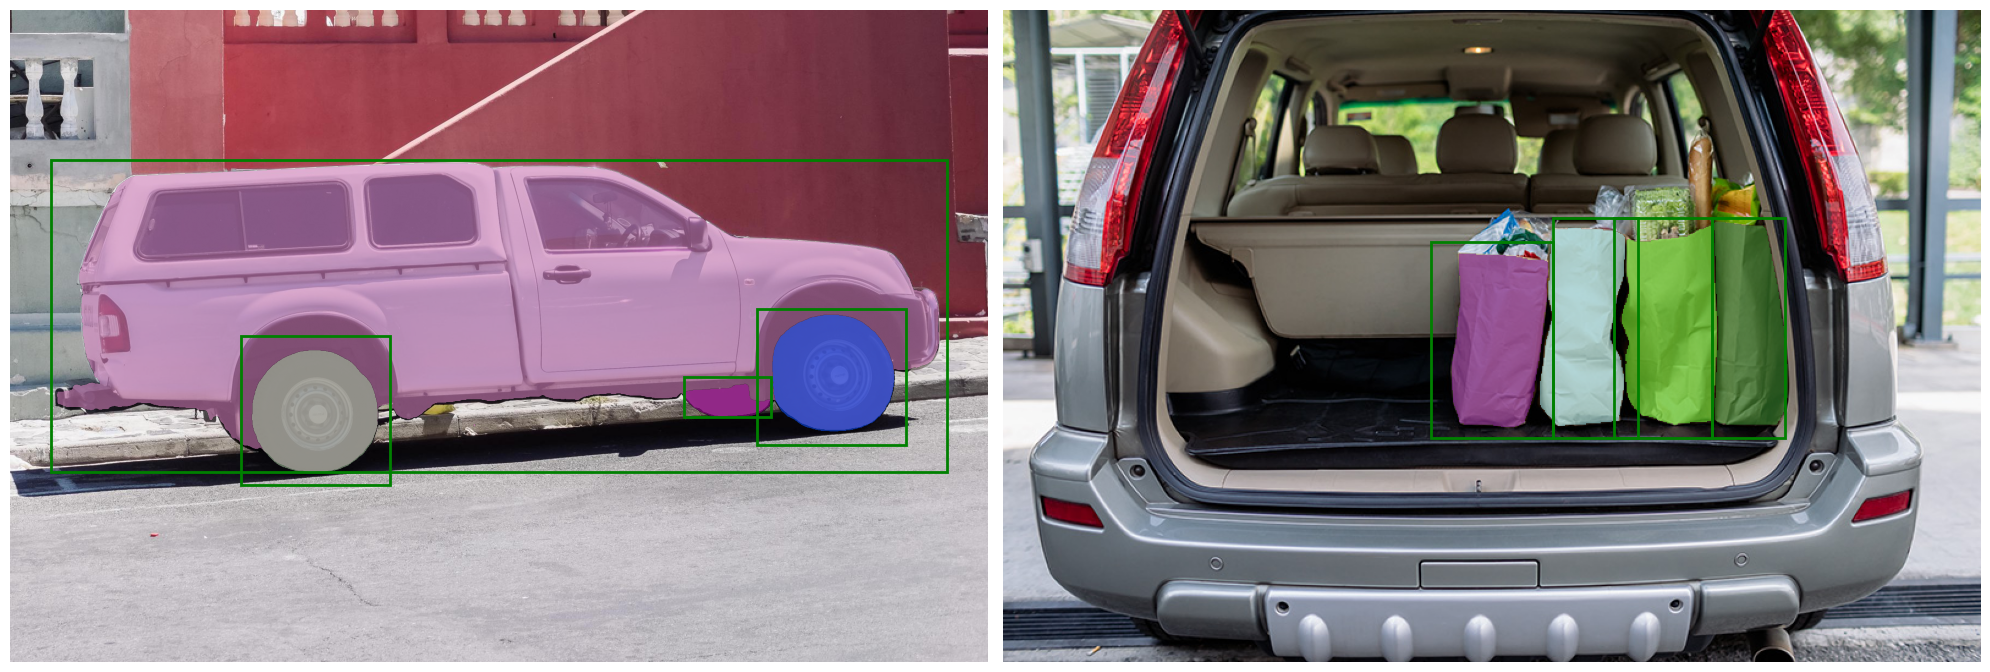

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(image1)
for mask in batched_output[0]['masks']:
    mask = ops.cast(mask > 0.0, dtype="float32")
    show_mask(ops.convert_to_numpy(mask), ax[0], random_color=True)
for box in image1_boxes:
    show_box(box, ax[0])
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    mask = ops.cast(mask > 0.0, dtype="float32")
    show_mask(ops.convert_to_numpy(mask), ax[1], random_color=True)
for box in image2_boxes:
    show_box(box, ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()